# Exercise containing ACA and u-ACA computation for different link cut strategies

Authors: Carlos Natalino, Marija Furdek and Amaro de Sousa

Paper used as basis: [IEEEXplore](https://www.sciencedirect.com/science/article/pii/S1573427718300535)

In [1]:
# importing libraries required for this example
import networkx as nx
import networkx.algorithms.centrality as nxcentrality
import numpy as np
import datetime
import math

import matplotlib as mpl
import matplotlib.pyplot as plt

from operator import itemgetter

import reader
from cdn_functions import a2tr, aca

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import logging
logging.getLogger('matplotlib').setLevel(logging.FATAL)

from matplotlib import rcParams

lpsolve supported
gurobi not supported
CPLEX not supported


## Define the inputs used by the example

In [2]:
# topology = 'Germany50'
topology = 'Coronet'

export_format = 'svg' # you can set the format to pdf, png, eps, etc.

# load the topology
graph = reader.read_file(f'./topologies/{topology}.txt', topology)

# placing DCs in defined places
# uncomment to use

# placement_dcs = ['11', '33', '46'] # optimal for Germany50 with 3 DCs
# placement_dcs = ['11', '22', '25', '38'] # optimal for Germany50 with 4 DCs

# placing a given number of DCs in random places
num_dcs = 3 # define here the number of DCs you want
placement_dcs = np.random.choice([node for node in graph.nodes()], size=num_dcs)

# define the number of links to be removed for the particular disaster studied
# Germany50 has 88 links
# Coronet has 99 links
num_links_to_remove = 40

Germany50             |  Coronet
:-------------------------:|:-------------------------:
![](./figures/Germany50_original.svg)  |  ![](./figures/Coronet_original.svg)

## Reading general inputs

In [3]:
fig_size = {}
fig_size['Coronet'] = (9, 6)
fig_size['Germany50'] = (6, 8)

## Plotting original topology

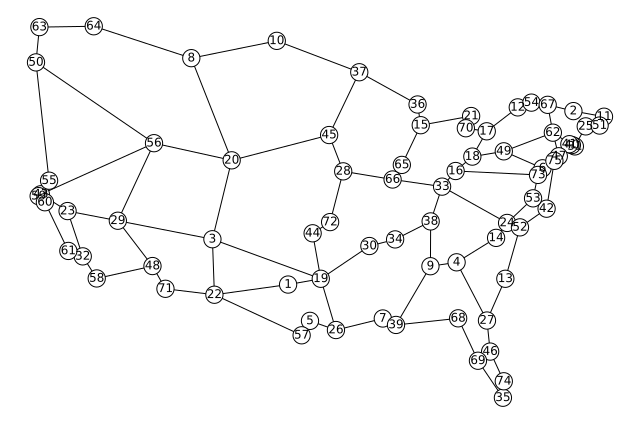

In [4]:
plt.figure(figsize=fig_size[topology])
pos = nx.get_node_attributes(graph, 'pos')
plt.axis('off')
nx.draw_networkx(graph, pos, node_color='white', edgecolors='black')
plt.tight_layout()
# plt.savefig(f'./figures/{topology}.{export_format}') # you can set the format to pdf, png, eps, etc.
plt.show()
plt.close()

## Defining the DC placement

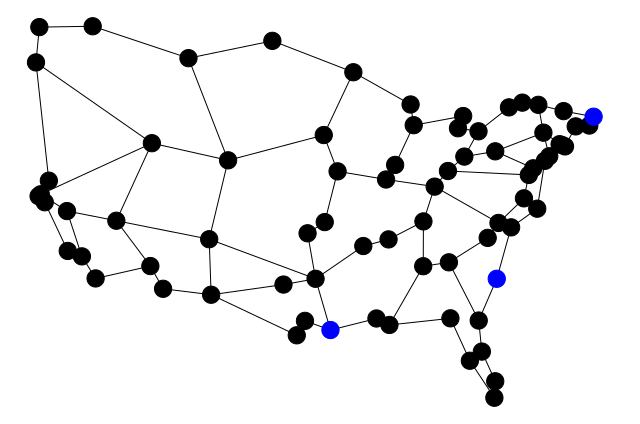

In [5]:
graph.graph['dcs'] = placement_dcs
plt.figure(figsize=fig_size[topology])
pos = nx.get_node_attributes(graph, 'pos')

plt.axis('off')
nx.draw_networkx_edges(graph, pos)
nx.draw_networkx_nodes(graph, pos, nodelist=[node for node in graph.nodes() if node not in placement_dcs], node_color='black')
nx.draw_networkx_nodes(graph, pos, nodelist=[node for node in graph.nodes() if node in placement_dcs], node_color='blue')

plt.tight_layout()
plt.savefig(f'./figures/{topology}_dc_placement.{export_format}') # you can set the format to pdf, png, eps, etc.
plt.show()
plt.close()

## Ploting ATTR, ACA and u-ACA

In [6]:
cur_graph = nx.Graph(graph) # make a copy of the topology
links_betweenness = sorted(nxcentrality.edge_betweenness_centrality(cur_graph).items(), key=itemgetter(1), reverse=True) # sorted links for removal

a2tr_values = []
aca_values = []

a2tr_values.append(a2tr(cur_graph, graph))
aca_values.append(aca(cur_graph, graph))

for link, bw in links_betweenness:
    cur_graph.remove_edge(link[0], link[1])
    a2tr_values.append(a2tr(cur_graph, graph))
    aca_values.append(aca(cur_graph, graph))

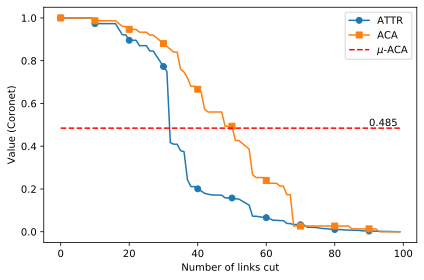

In [7]:
plt.figure()
plt.plot(a2tr_values, label='ATTR', marker='o', markevery=10)
plt.plot(aca_values, label='ACA', marker='s', markevery=10)
plt.plot(range(len(aca_values)), np.tile(np.mean(aca_values), len(aca_values)), label='$\mu$-ACA', linestyle='--', color='red')
plt.text(len(aca_values)-10, np.mean(aca_values)+.01, '{:.3f}'.format(np.mean(aca_values)))

plt.xlabel('Number of links cut')
plt.ylabel(f'Value ({topology})')
plt.legend(loc=1)
plt.tight_layout()
plt.savefig(f'./figures/{topology}_aca_versus_attr.{export_format}') # you can set the format to pdf, png, eps, etc.
plt.show()

## Plot topology with given number of link cuts

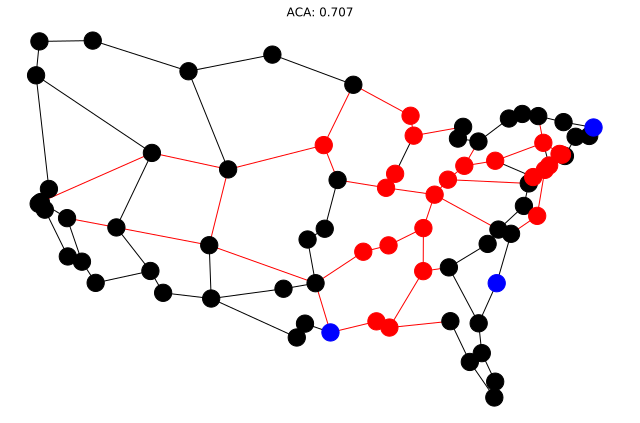

In [8]:
cur_graph = nx.Graph(graph) # make a copy of the topology
links_betweenness = sorted(nxcentrality.edge_betweenness_centrality(cur_graph).items(), key=itemgetter(1), reverse=True) # sorted links for removal
removed_links = []
for link, bw in links_betweenness:
    removed_links.append(link)
    cur_graph.remove_edge(link[0], link[1])
    if len(removed_links) == num_links_to_remove or cur_graph.number_of_edges() == 0: # makes sure to stop when there are no more links to cut
        break

plt.figure(figsize=fig_size[topology])
pos = nx.get_node_attributes(graph, 'pos')

plt.axis('off')
nx.draw_networkx_edges(cur_graph, pos, edge_color='black')
nx.draw_networkx_edges(graph, pos, edge_color='red', edgelist=removed_links)

disconnected_nodes = []
for n1 in graph.nodes():
    connected = False
    for dc in graph.graph['dcs']:
        if n1 != dc and n1 in cur_graph.nodes() and dc in cur_graph.nodes():
            if dc in nx.algorithms.descendants(cur_graph, n1):
                connected = True
    if not connected:
        disconnected_nodes.append(n1)

aca_value = (len(placement_dcs) + graph.number_of_nodes() - len(disconnected_nodes)) / graph.number_of_nodes()
plt.title('ACA: {:.3f}'.format(aca_value))

nx.draw_networkx_nodes(graph, pos, nodelist=[node for node in graph.nodes() if node not in placement_dcs and node not in disconnected_nodes], node_color='black')
nx.draw_networkx_nodes(graph, pos, nodelist=[node for node in graph.nodes() if node in placement_dcs], node_color='blue')
nx.draw_networkx_nodes(graph, pos, nodelist=[node for node in disconnected_nodes if node not in placement_dcs], node_color='red')

plt.tight_layout()
plt.savefig(f'./figures/{topology}_dc_placement.{export_format}') # you can set the format to pdf, png, eps, etc.
plt.show()
plt.close()